In [48]:
from __future__ import print_function
import os
import torchvision.models as models
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pickle
import urllib
import time
import copy

%matplotlib inline

In [20]:
def show_images(loader):
    d = iter(loader)
    images, labels = d.next()
    grid = torchvision.utils.make_grid(images)
    npimg = grid.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = std * npimg + mean
    print(labels)
    plt.imshow(npimg)
    plt.show()
    
def show_image_batch(images):
    grid = torchvision.utils.make_grid(images)
    npimg = grid.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = std * npimg + mean
    plt.imshow(npimg)
    plt.show()

In [27]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            


In [30]:
num_classes = 2
num_epochs = 1
feature_extract = True

In [37]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.mobilenet_v2(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[1].in_features
    model_ft.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)
    input_size = 224
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [58]:
traindir = os.path.join(os.getcwd(), 'train')
testdir = os.path.join(os.getcwd(), 'test')

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(traindir, transform),
    shuffle=True,
    batch_size=4,
    num_workers=2)
test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(testdir, transform),
    batch_size=4,
    num_workers=2)

data_transforms = {
    'train': transform,
    'val': transform
}

dataloaders_dict = {
    'train': train_loader,
    'val': test_loader
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Done Initializing Datasets and Dataloaders...")


Done Initializing Datasets and Dataloaders...


tensor([1, 0, 1, 0])


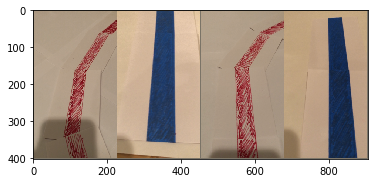

In [59]:
show_images(train_loader)

In [53]:
# Send the model to GPU/CPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(params_to_update)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [65]:
# Setup the loss fxn
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2738 Acc: 0.8959
val Loss: 0.1137 Acc: 0.9546

Epoch 1/24
----------
train Loss: 0.2050 Acc: 0.9205
val Loss: 0.0427 Acc: 0.9821

Epoch 2/24
----------
train Loss: 0.1957 Acc: 0.9295
val Loss: 0.0617 Acc: 0.9753

Epoch 3/24
----------
train Loss: 0.2674 Acc: 0.9061
val Loss: 0.0356 Acc: 0.9843

Epoch 4/24
----------
train Loss: 0.2166 Acc: 0.9131
val Loss: 0.0340 Acc: 0.9843

Epoch 5/24
----------
train Loss: 0.2494 Acc: 0.9111
val Loss: 0.0201 Acc: 0.9938

Epoch 6/24
----------
train Loss: 0.2042 Acc: 0.9279
val Loss: 0.0288 Acc: 0.9888

Epoch 7/24
----------
train Loss: 0.2233 Acc: 0.9201
val Loss: 0.0172 Acc: 0.9938

Epoch 8/24
----------
train Loss: 0.2325 Acc: 0.9172
val Loss: 0.0197 Acc: 0.9922

Epoch 9/24
----------
train Loss: 0.1972 Acc: 0.9324
val Loss: 0.0134 Acc: 0.9955

Epoch 10/24
----------
train Loss: 0.1894 Acc: 0.9348
val Loss: 0.0088 Acc: 0.9978

Epoch 11/24
----------
train Loss: 0.2378 Acc: 0.9209
val Loss: 0.0074 Acc: 0.9994

Ep

In [64]:
torch.save({'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict()
            }, './state_dict_20191102-16-42')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


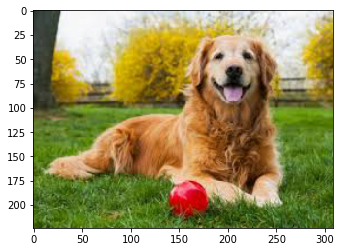

golden retriever
207


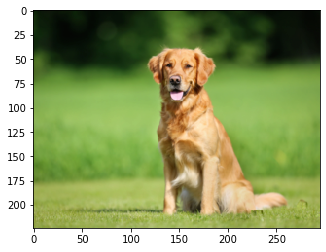

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


golden retriever
207


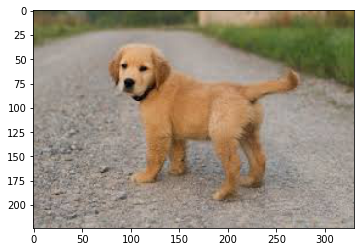

golden retriever
207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


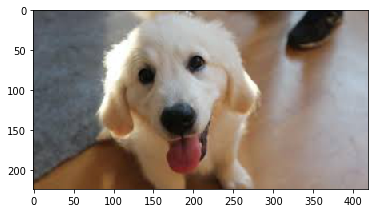

golden retriever
207


In [14]:
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        show_image_batch(images)
        _, predicted = torch.max(outputs.data, 1)
        print(imagenet_labels[predicted.item()])
        print(predicted.item())